# Save Wally!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import savewally
from importlib import reload
from PIL import Image
from skimage import feature

In [2]:
df = pd.read_csv("data/Linga Holm_ORKlh_2016_3&4_20180906.csv")
df = df[df.image_file =='StitchMICE_ORKlh16_3_1104_CP_FINAL.tif']

## Append filepaths to dataframe

In [3]:
# loop over every row
k = 8  # level
filepaths = []
for i, row in df.iterrows():
    row, col = savewally.LocateTile(row.x, row.y, savewally.SizeTile)
    filepaths.append(savewally.GetFilepath(k, row, col))
df["fp"] = filepaths

In [4]:
df["class"].unique()

array(['whitecoat', 'moulted', 'dead', 'double'], dtype=object)

## Load images

In [5]:
images = []
image_filepaths = []
for fp in df.fp.unique():  # [df["class"]=="whitecoat"]
    im = Image.open("data/Stitch_3/" + fp)
    images.append(im)
    image_filepaths.append(fp)

In [6]:
def plot_rect(img, x, y, dx, dy):
    patch, bbox = extract_patch(img, x, y, dx, dy)
    extent = bbox[0], bbox[2], bbox[1], bbox[3]
    # plot tile
    plt.imshow(np.asarray(img)[::-1,:,:])
    # plot seal loc
    plt.scatter(x, y)
    # plot patch
    plt.imshow(patch[::-1,:,:], extent=extent,  alpha=1)
    plt.imshow(np.ones(patch[::-1,:,:].shape), extent=extent,  alpha=0.3)
    plt.xlim(0,256)
    plt.ylim(0,256)

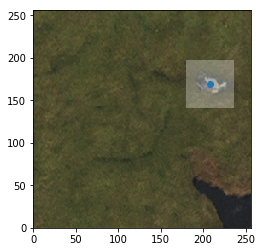

In [203]:
x, y = df[df.fp == image_filepaths[38]].x.values[0], df[df.fp == image_filepaths[38]].y.values[0]
plot_rect(images[38], x%256, y%256, 28, 28)

# Generate patches

In [315]:
def do_box(x, y, dx, dy):
    return  x - dx, y - dy, x + dx, y + dy 

def overlap(b1,b2):
    hoverlaps = (b1[0] <= b2[2]) and (b1[2] >= b2[0])
    voverlaps = (b1[3] >= b2[1]) and (b1[1] <= b2[3])
    return hoverlaps and voverlaps

def extract_patch(img, x, y, dx, dy):
    """
    x,y need to be in image coordinates!
    """
    box = do_box(x, y, dx, dy)  # bounding box
    patch = np.asarray(img)[::-1,:,:][box[1]:box[3], box[0]:box[2]]  # extract patch from image array
    return patch, box

In [8]:
dx, dy = 32, 32

In [9]:
import tqdm

In [157]:
reload(savewally)

<module 'savewally' from 'C:\\Users\\r02as18\\git\\savewally\\savewally\\__init__.py'>

In [318]:
def extract_random_patches(img, fp, n_patches, plot=False, dx=32, dy=32, drop_true=False):
    patches = []
    patches_boxes = []
    patches_bool = []
    patches_fp = []
    patches_overlap_ratio = []

    for n in range(n_patches):
        # generate a random point
        x,y = (np.random.randint(dx, 256 - dx), 
               np.random.randint(dy, 256 - dy))
        # extract a patch, and the patch box
        patch, patch_box = extract_patch(img, x, y, dx, dy)
              
        if plot:
            plot_rect(img, x, y, dx, dy)
        
        # check if it overlaps with a seal
        seals = df[(df.fp==fp)]  # grab all the seal coordinates of the tile  #  & (df["class"]=="whitecoat")
        seals_bool = []
        seals_overlap = []
        for i, seal in seals.iterrows():
            # there is at least 1 seal in the image
            # create a seal box
            seal_box = do_box(seal.x%256, seal.y%256, dx, dy)
            # check if the two boxes overlap
            is_seal = overlap(seal_box, patch_box)
            seals_bool.append(is_seal)
            
            if is_seal:
                overlap_ratio = savewally.overlap_area(seal_box, patch_box, dx, dy)
            else:
                overlap_ratio = 0
            
            seals_overlap.append(overlap_ratio)
            
            if plot:
                print(is_seal)
        
        is_seal = bool(np.count_nonzero(seals_bool))
        if len(seals_overlap) > 0:
            patches_overlap_ratio = np.append(patches_overlap_ratio, np.max(seals_overlap))
        else:
            patches_overlap_ratio = np.append(patches_overlap_ratio, 0)
        # patches_overlap_ratio.append(overlap_ratio)
        # patches_overlap_ratio.append(0)
        
        if drop_true:
            if is_seal:
                continue
        
        # store
        patches.append(patch)  # image patches
        patches_boxes.append(patch_box)  # patch bounding box
        patches_fp.append(fp)  # filepath
        patches_bool.append(is_seal)  # store bool
            
    return patches, patches_boxes, patches_bool, patches_fp, patches_overlap_ratio

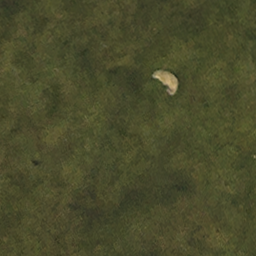

In [165]:
images[39]

True
[0.4275]


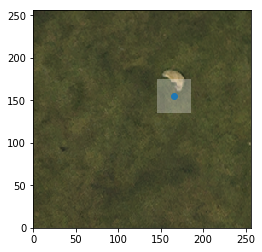

In [190]:
_ = extract_random_patches(images[39], image_filepaths[39], 1, plot=True, dx=20, dy=20)
print(_[-1])

In [115]:
dx, dy = 20, 20

In [319]:
storage_patches = np.empty((0, 2*dx, 2*dy, 4))
storage_boxes = np.empty((0,4))
storage_bool = np.empty((0))
storage_fp = np.empty((0))
storage_overlap = np.empty((0))

for img, fp in zip(images, image_filepaths):
    # extract random patches from image:
    patches, boxes, patches_bool, patches_fp, patches_overlap = extract_random_patches(img, fp, 10, 
                                                                      dx=dx, dy=dy, drop_true=False)
    # store random patches
    storage_patches = np.append(storage_patches, np.array(patches), axis=0)
    storage_boxes = np.append(storage_boxes, np.array(boxes), axis=0)
    storage_bool = np.append(storage_bool, np.array(patches_bool), axis=0)
    storage_fp = np.append(storage_fp, np.array(patches_fp), axis=0)
    storage_overlap = np.append(storage_overlap, np.array(patches_overlap), axis=0)
    
#     # extract seal patch from image
#     seals = df[(df.fp==fp) & (df["class"]=="whitecoat")]  # grab all the seal coordinates of the tile
#     for i, seal in seals.iterrows():
#         try:
#             patch, patch_box = extract_patch(img, seal.x%256, seal.y%256, dx, dy)

#             storage_patches = np.append(storage_patches, np.array(patch), axis=0)
#             storage_boxes = np.append(storage_boxes, np.array(patch_box), axis=0)
#             storage_bool = np.append(storage_bool, np.array([True]), axis=0)
#             storage_fp = np.append(storage_fp, np.array([fp]), axis=0)
#             storage_overlap = np.append(storage_overlap, np.array([1]), axis=1)
#         except ValueError:
#             pass

KeyboardInterrupt: 

In [133]:
def save(affix):
    np.save("data/storage_patches_"+str(affix)+".npy", storage_patches)
    np.save("data/storage_boxes_"+str(affix)+".npy", storage_boxes)
    np.save("data/storage_bool_"+str(affix)+".npy", storage_bool)
    np.save("data/storage_fp_"+str(affix)+".npy", storage_fp)
    

def load(affix):
    storage_patches = np.load("data/storage_patches_"+str(affix)+".npy")
    storage_boxes = np.load("data/storage_boxes_"+str(affix)+".npy")
    storage_bool = np.load("data/storage_bool_"+str(affix)+".npy")
    storage_fp = np.load("data/storage_fp_"+str(affix)+".npy")
    return storage_patches, storage_boxes, storage_bool, storage_fp

In [219]:
save("20x20y_whitecoat_overlap")

In [312]:
storage_patches.shape

(5038, 40, 40, 4)

### Load the real seals

In [320]:
seal_patches = np.load("data/seal_patches.npy")

In [ ]:
fig, axes = plt.subplots(nrows=10, ncols=8)

for patch, ax in zip(seal_patches, axes.flat):
    ax.imshow(patch)

### Load random patches

In [321]:
storage_patches, storage_boxes, storage_bool, storage_fp = load("20x20y")

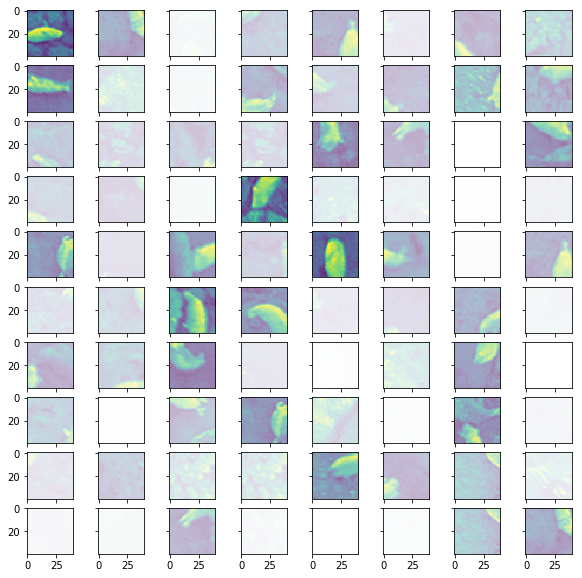

In [224]:
pos_loc = np.where(storage_bool == True)[0]
np.random.seed(21)
sample = np.random.choice(pos_loc, 80)

fig, axes = plt.subplots(nrows=10, ncols=8, sharex=True, sharey=True, figsize=(10,10))
for patch, ov, ax in zip(storage_patches[sample], storage_overlap[sample], axes.flat):
    ax.imshow(patch[:,:,0], alpha=ov)

### Merge

In [326]:
seal_patches.shape

(3041, 40, 40, 3)

In [329]:
storage_patches[:,:,:,:2].shape

(25190, 40, 40, 2)

In [332]:
patches = np.append(storage_patches[:,:,:,:3], seal_patches, axis=0)
labels = np.append(storage_bool, np.ones(len(seal_patches)), axis=0)

### Greyscale images, HOGs

In [335]:
hogs = []

for patch in patches:
    greyscale = savewally.RGB2Lum(patch)
    hog_vec = feature.hog(greyscale, visualize=False)
    hogs.append(hog_vec)

C:\Users\r02as18\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


In [337]:
X = np.array(hogs)
y = np.array(labels)# [:,np.newaxis]
#w = storage_overlap
#w[np.where(y==0)[0]] = 1.

In [290]:
np.where(w > 0.4)

(array([   0,    1,    2, ..., 5035, 5036, 5037], dtype=int64),)

In [302]:
y_new = y

In [303]:
y_new[(y==1) & (w < 0.2)] = 0.

In [228]:
X.shape

(5038, 729)

In [229]:
y.shape

(5038, 1)

In [264]:
w.shape

(5038,)

In [267]:
yy = np.stack((y,w), axis=1)

In [ ]:
pd.DataFrame(columns=)

In [339]:
from sklearn.model_selection import train_test_split

X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)

In [361]:
n = X.shape[0] * 0.4

In [376]:
np.random.seed(32)
i_train = np.random.randint(0, X.shape[0], size=int(n))
bool_test = np.ones((X.shape[0])).astype(bool)
bool_test[i_train] = False

X_train = X[i_train]
y_train = y[i_train]

X_test = X[bool_test]
y_test = y[bool_test]

In [377]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [378]:
score = clf.score(X_test, y_test)

In [391]:
X_test[i].shape

(729,)

In [425]:
wrong = [17530, 18777]

17530

prediction:  [1.]


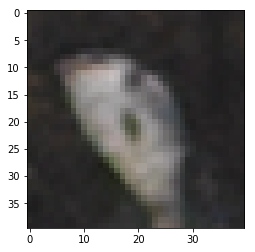

In [470]:
# np.random.seed(23)
i = np.random.choice(np.where(y_test == 1.)[0])

print("prediction: ", clf.predict(X_test[np.newaxis,i]))

plt.imshow(patches[bool_test][i][:,:,:3].astype(int))

* make plot of positives, negatives, false pos, false neg
* make sliding window over crop, heat map of prediction

In [379]:
score

0.9030566297610849

# Sliding image

In [476]:
test_image = Image.open("data/test_image.png")

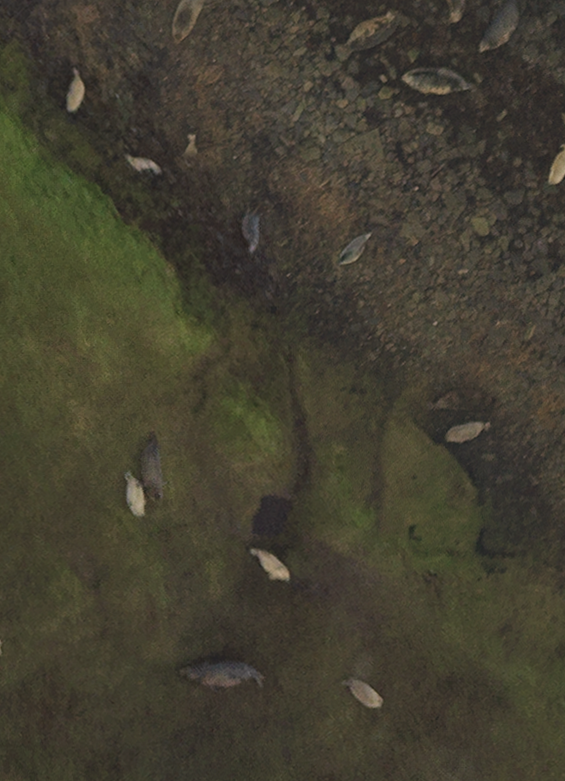

In [477]:
test_image

In [508]:
def sliding_window(img, istep=10, jstep=10, scale=1., patch_size=(40,40)):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

In [509]:
indices, patches = zip(*sliding_window(np.asarray(test_image)))

In [510]:
hogs = []
for patch in patches:
    greyscale = savewally.RGB2Lum(patch)
    hog_vec = feature.hog(greyscale, visualize=False)
    hogs.append(hog_vec)

In [511]:
hogs = np.array(hogs)

In [512]:
hogs.shape

(3975, 729)

In [514]:
labels = clf.predict(hogs)

In [517]:
Ni, Nj = (40,40)
indices = np.array(indices)

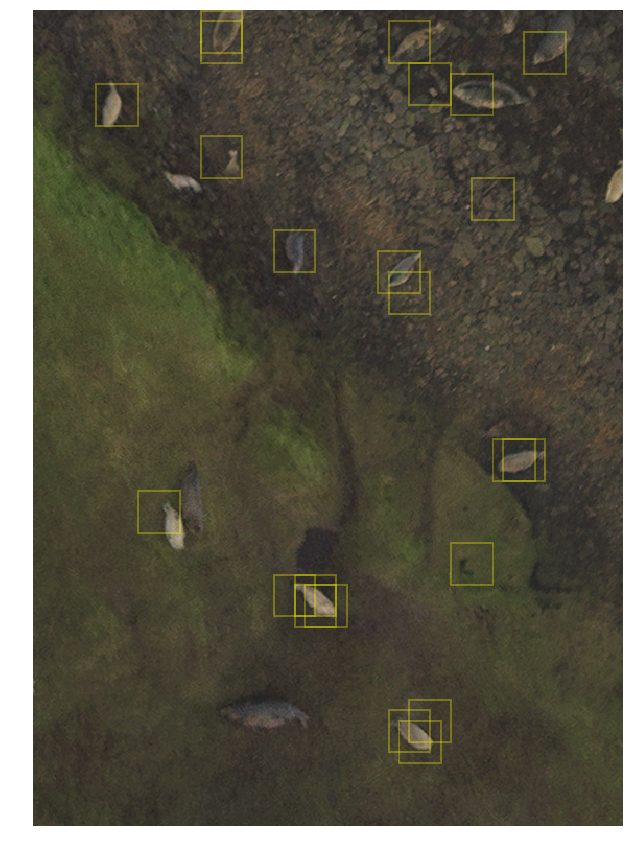

In [522]:
fig, ax = plt.subplots(figsize=(20,15))
ax.imshow(np.asarray(test_image), cmap='gray')
ax.axis('off')

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='yellow',
                               alpha=0.3, lw=2, facecolor='none'))